Date         0
open        10
high        10
low         10
close       10
adjclose    10
volume      10
ticker       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7124 entries, 0 to 7123
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      7124 non-null   object 
 1   open      7114 non-null   float64
 2   high      7114 non-null   float64
 3   low       7114 non-null   float64
 4   close     7124 non-null   float64
 5   adjclose  7114 non-null   float64
 6   volume    7114 non-null   float64
 7   ticker    7124 non-null   object 
dtypes: float64(6), object(2)
memory usage: 445.4+ KB
None
              open         high          low        close     adjclose  \
count  7114.000000  7114.000000  7114.000000  7124.000000  7114.000000   
mean    591.130540   597.880684   583.915747   590.217135   569.978958   
std     726.794518   733.856886   719.397112   725.992518   727.268604   
min      10.9251

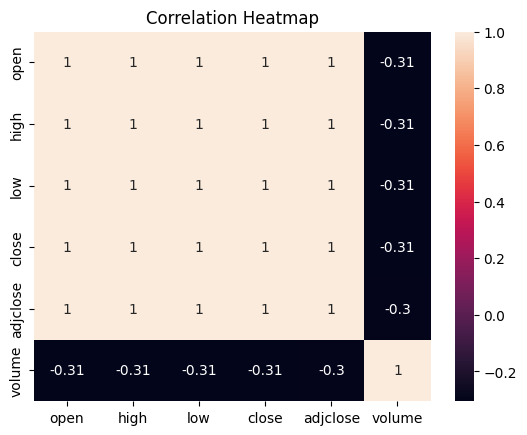

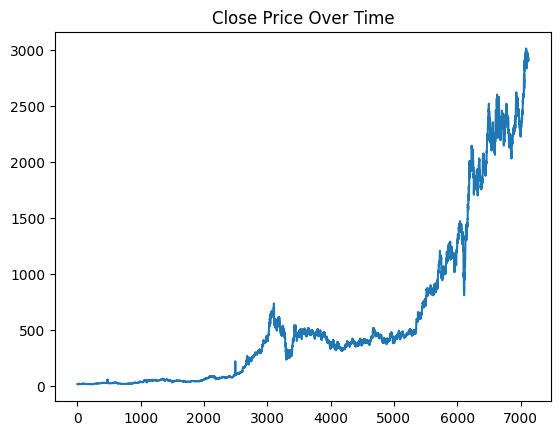

Feature columns types:
 open           float64
high           float64
low            float64
volume         float64
year             int32
month            int32
day              int32
day_of_week      int32
dtype: object

XGBoost Performance:
RMSE: 1111.9719
MAE: 961.1229
R2: -3.0152
Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - loss: 0.0014
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 1.2683e-04
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 1.1759e-04
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 1.0526e-04
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 1.1062e-04
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 8.4317e-05
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 7.8615e-05
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 7.3202e-05
Epoch 9/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 6.5724e-05
Epoch 10/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvv6zlhs1/ym8cxmge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvv6zlhs1/lvthf2qg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12733', 'data', 'file=/tmp/tmpvv6zlhs1/ym8cxmge.json', 'init=/tmp/tmpvv6zlhs1/lvthf2qg.json', 'output', 'file=/tmp/tmpvv6zlhs1/prophet_modelsx2yvcnr/prophet_model-20250528162551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


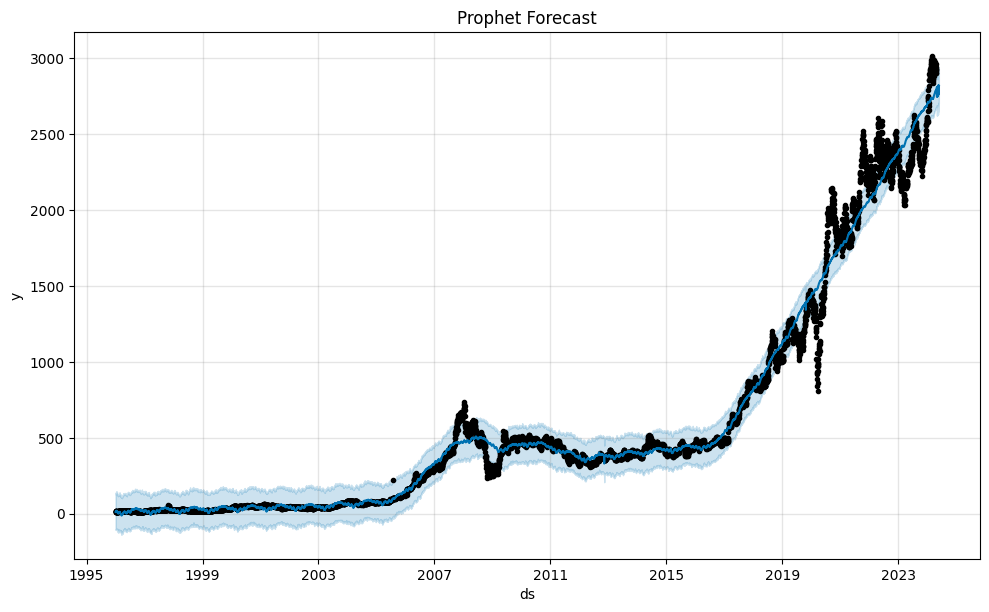


Prophet Performance:
RMSE: 131.4150
MAE: 124.5952
R2: -11.0283

Ensemble Performance:
RMSE: 1066.6580
MAE: 1065.9503
R2: -791.4390


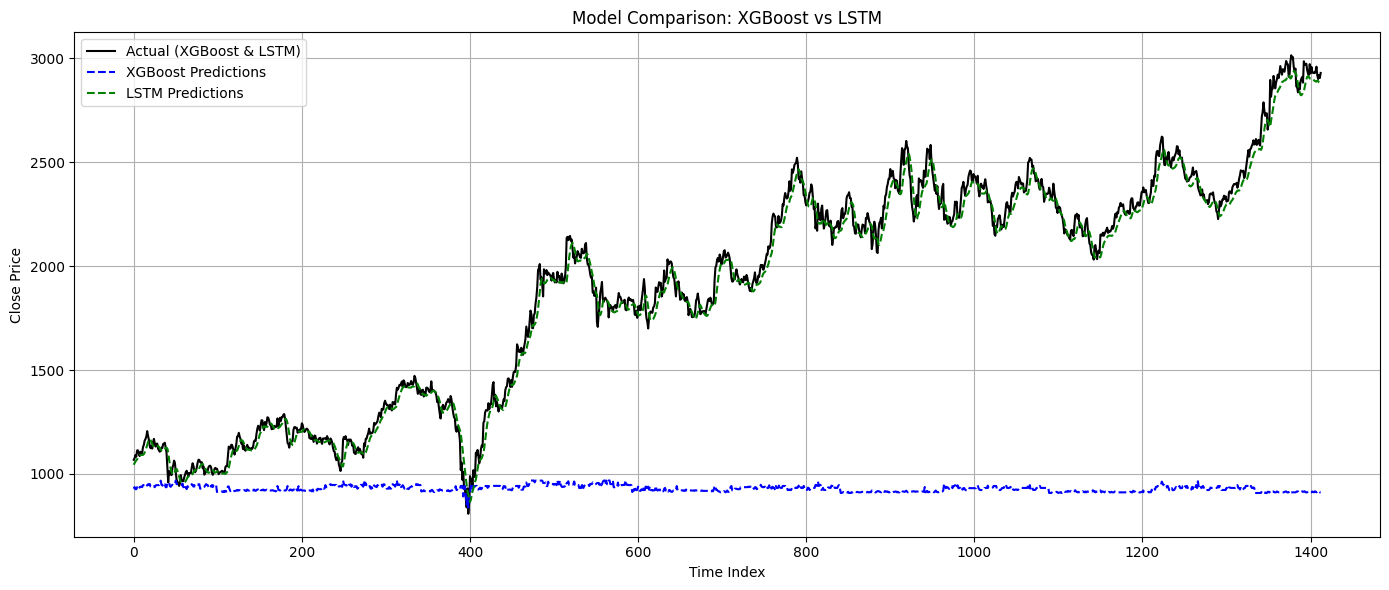


Model Performance Comparison:
Model            RMSE        MAE         R2
XGBoost     1116.6505   968.5270    -3.0985
LSTM          55.3059    42.8116     0.9899


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings("ignore")

# Load the data
df = pd.read_csv('RELIANCE.NS_stock_data.csv')
print(df.isnull().sum())

# Drop or fill NaNs in 'close'
df['close'] = df['close'].fillna(method='ffill')

# EDA
print(df.info())
print(df.describe())

# Plot heatmap - ensure only numeric columns are included
numeric_df = df.select_dtypes(include=[np.number])
print("Numeric columns:", numeric_df.columns.tolist())

sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

df['close'].plot(title='Close Price Over Time')
plt.show()

# Feature engineering
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')
df.set_index('Date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek

# Confirm no string columns are included in features
features = ['open', 'high', 'low', 'volume', 'year', 'month', 'day', 'day_of_week']
print("Feature columns types:\n", df[features].dtypes)

# Train-test split
X = df[features]
y = df['close']
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y = y.fillna(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# XGBoost with hyperparameter tuning
xgb = XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
}
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("\nXGBoost Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.4f}")
print(f"R2: {r2_score(y_test, y_pred_xgb):.4f}")

# LSTM Model
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['close']])  # Fit the scaler properly

# Prepare data for LSTM
X_lstm, y_lstm = [], []
window_size = 60
for i in range(window_size, len(df_scaled)):
    X_lstm.append(df_scaled[i-window_size:i, 0])
    y_lstm.append(df_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_train_lstm = X_lstm[:int(0.8*len(X_lstm))]
X_test_lstm = X_lstm[int(0.8*len(X_lstm)):]
y_train_lstm = y_lstm[:int(0.8*len(y_lstm))]
y_test_lstm = y_lstm[int(0.8*len(y_lstm)):]

X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

if np.isnan(X_train_lstm).any() or np.isnan(y_train_lstm).any():
    print("Warning: NaN values found in training data. Replacing with mean.")
    X_train_lstm = np.nan_to_num(X_train_lstm, np.nanmean(X_train_lstm))
    y_train_lstm = np.nan_to_num(y_train_lstm, np.nanmean(y_train_lstm))

model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32)

# Predictions and rescaling
y_pred_lstm = model.predict(X_test_lstm)

# Inverse scale the predictions and true values
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

print("\nLSTM Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_lstm_rescaled, y_pred_lstm_rescaled)):.4f}")
print(f"MAE: {mean_absolute_error(y_test_lstm_rescaled, y_pred_lstm_rescaled):.4f}")
print(f"R2: {r2_score(y_test_lstm_rescaled, y_pred_lstm_rescaled):.4f}")

# Prophet
prophet_df = df.reset_index()[['Date', 'close']]
prophet_df.columns = ['ds', 'y']
prophet = Prophet()
prophet.fit(prophet_df)

future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

# Plot forecast
prophet.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Prophet accuracy (for last 30 days of original data)
actual_len = len(prophet_df)
if actual_len >= 30:
    y_true = prophet_df['y'][-30:].values
    y_pred_prophet = forecast['yhat'][-30:].values

    print("\nProphet Performance:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred_prophet)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred_prophet):.4f}")
    print(f"R2: {r2_score(y_true, y_pred_prophet):.4f}")

    # Optional ensemble (simple average)
    ensemble_pred = (y_pred_xgb[-30:] + y_pred_prophet) / 2
    print("\nEnsemble Performance:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, ensemble_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, ensemble_pred):.4f}")
    print(f"R2: {r2_score(y_true, ensemble_pred):.4f}")
else:
    print("\nNot enough data for Prophet accuracy evaluation (need at least 30 days).")

# Inverse transform LSTM predictions and actuals (if not already done)
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Match lengths for plotting (XGBoost and LSTM test sets are separate)
# We'll take the last part of `y_test` to match the LSTM test set size for fair comparison
y_test_xgb_aligned = y_test[-len(y_test_lstm_rescaled):]
y_pred_xgb_aligned = y_pred_xgb[-len(y_test_lstm_rescaled):]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test_xgb_aligned.values, label='Actual (XGBoost & LSTM)', color='black')
plt.plot(y_pred_xgb_aligned, label='XGBoost Predictions', linestyle='--', color='blue')
plt.plot(y_pred_lstm_rescaled, label='LSTM Predictions', linestyle='--', color='green')
plt.title('Model Comparison: XGBoost vs LSTM')
plt.xlabel('Time Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# LSTM metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_rescaled, y_pred_lstm_rescaled))
mae_lstm = mean_absolute_error(y_test_lstm_rescaled, y_pred_lstm_rescaled)
r2_lstm = r2_score(y_test_lstm_rescaled, y_pred_lstm_rescaled)

# XGBoost metrics (already computed earlier, now reused)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb_aligned, y_pred_xgb_aligned))
mae_xgb = mean_absolute_error(y_test_xgb_aligned, y_pred_xgb_aligned)
r2_xgb = r2_score(y_test_xgb_aligned, y_pred_xgb_aligned)

# Print comparison table
print("\nModel Performance Comparison:")
print(f"{'Model':<10} {'RMSE':>10} {'MAE':>10} {'R2':>10}")
print(f"{'XGBoost':<10} {rmse_xgb:>10.4f} {mae_xgb:>10.4f} {r2_xgb:>10.4f}")
print(f"{'LSTM':<10} {rmse_lstm:>10.4f} {mae_lstm:>10.4f} {r2_lstm:>10.4f}")


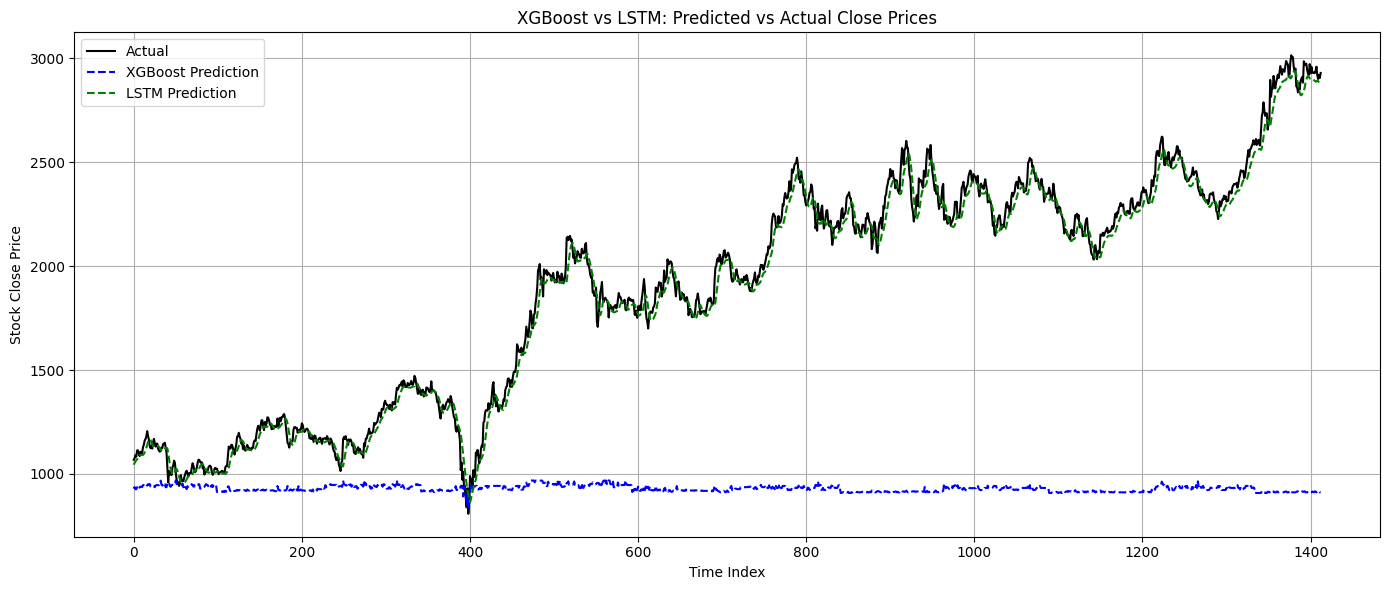

In [5]:
# Combined prediction plot
plt.figure(figsize=(14, 6))
plt.plot(y_test_xgb_aligned.values, label='Actual', color='black')
plt.plot(y_pred_xgb_aligned, label='XGBoost Prediction', linestyle='--', color='blue')
plt.plot(y_pred_lstm_rescaled, label='LSTM Prediction', linestyle='--', color='green')
plt.title('XGBoost vs LSTM: Predicted vs Actual Close Prices')
plt.xlabel('Time Index')
plt.ylabel('Stock Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import pickle

# XGBoost
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

# LSTM
model.save("model.h5")  # Keras model

# Prophet (optional, can retrain dynamically or save components)
with open("prophet.pkl", "wb") as f:
    pickle.dump(model, f)


In [ ]:
from flask import Flask, request, jsonify
import pickle
import numpy as np
from tensorflow.keras.models import load_model

# Load models
xgb_model = pickle.load(open("xgb_model.pkl", "rb"))
lstm_model = load_model("model.h5")

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

prophet = pickle.load(open("prophet.pkl", "rb"))

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    model_id = data.get("model_id")
    features = np.array(data.get("features"))

    if model_id == "xgb":
        prediction = xgb_model.predict([features])
    elif model_id == "lstm":
        # Ensure input is 3D: (samples, timesteps, features)
        features = np.array(features).reshape(1, len(features), 1)
        prediction = model.predict(features)
    else:
        return jsonify({"error": "Invalid model_id"}), 400

    return jsonify({"prediction": prediction.tolist()})

if __name__ == '__main__':
    app.run(debug=True)
